# Generation of FBM
> Leveraging SPIVAE to create new FBM trajectories.

The goal of this tutorial is to generate new trajectories from the trained SPIVAE and examine their attributes to evaluate the model's strengths and drawbacks.

In [ ]:
#|hide
from SPIVAE.imports import *

# Load model

We load the model to characterize from its checkpoint.

In [ ]:
DEVICE='cpu'
E=144
model_name = 'fbm' + f'_E{E}'
c_point, model = load_checkpoint("./models/"+model_name,device=DEVICE)

Loading checkpoint: ./models/fbm_E144.tar
on device: cpu


We can check the parameters of the data and the model.

In [ ]:
ds_args, model_args = c_point['ds_args'],c_point['model_args']
print(ds_args, model_args)

{'path': '../../data/raw/', 'model': 'fbm', 'N': 476, 'T': 400, 'D': array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02]), 'alpha': array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ,
       1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ]), 'seed': 0, 'valid_pct': 0.2, 'bs': 256, 'N_save': 6000, 'T_save': 400} {'o_dim': 399, 'nc_in': 1, 'nc_out': 6, 'nf': [16, 16, 16, 16], 'avg_size': 16, 'encoder': [200, 100], 'z_dim': 6, 'decoder': [100, 200], 'beta': 0.004, 'in_channels': 1, 'res_channels': 16, 'skip_channels': 16, 'c_channels': 6, 'g_channels': 0, 'res_kernel_size': 3, 'layer_size': 4, 'stack_size': 1, 'out_distribution': 'Normal', 'num_mixtures': 1, 'use_pad': False, 'model_name': 'SPIVAE'}


# Generate displacements

We generate new displacements from a range of values of the latent neurons.

In [ ]:
z_idx = 0 # 1
z_num = 60
z_range = torch.linspace(-4,4,z_num)
z_values = torch.zeros(z_num,6)
z_values[:,z_idx] = z_range

Then, we use the decoder to upsample the latent neurons we just created.

In [ ]:
c = model.vae._decode(z_values); print(c.shape)

torch.Size([60, 6, 399])


We choose the number of samples for each latent neuron value and the batch size for generation.

In [ ]:
samples_per_z = 6_00
total_samples = z_num*samples_per_z
bs = samples_per_z
assert not total_samples%bs, 'Using batched generation mode should be using a multiple of the batch size'

We sample from the model in a controlled manner with the conditions we just created from the latent neurons.

In [ ]:
disp_gen, logits = model.sample_batch(total_samples, bs=bs, c=c.repeat_interleave(samples_per_z,dim=0))

  0%|          | 0/60 [00:00<?, ?it/s]

And save it with proper dimensions for the analysis.

In [ ]:
fname = "../../data/gen/"+model_name+f'_disp_gen{z_idx}.npz'
os.makedirs('../../data/gen/', exist_ok=True)
if not os.path.exists(fname):
    disp_gen = disp_gen.squeeze().detach().cpu().numpy()
    disp_gen = disp_gen.reshape(z_num, samples_per_z, disp_gen.shape[-1])
    np.savez_compressed(fname, disp_gen=disp_gen)
    print("Saved at:", fname)
    print("with dimensions", disp_gen.shape)

Saved at: ../../data/gen/fbm_E144_disp_gen0.npz
with dimensions (60, 600, 200)


We can now repeat the above steps with the other _surviving_ neuron by changing the `z_idx` value.
Then, we have two sets of generated displacements corresponding to a range of values of the selected latent neurons.

# Analyze generated displacements

We analyze the diffusion properties of the displacements by means of standard statistical techniques.
The main approach consists in characterizing ensembles of displacements with the same properties,  averaging in time, samples, or both.

## Load generated displacements

In [ ]:
z_idx = 0
fname = "../../data/gen/"+model_name+f'_disp_gen{z_idx}.npz'
disp_gen0 = np.load(fname,)["disp_gen"]
z_idx = 1
fname = "../../data/gen/"+model_name+f'_disp_gen{z_idx}.npz'
disp_gen1 = np.load(fname,)["disp_gen"]

## Check generated displacements mean and variance

As a fast check of the generation, we can see if the displacements mean and variance are the expected.
For one neuron, we observe the mean varies more than for the other neuron, coinciding with the interpretation of these neurons with $D$ and $\alpha$. Both sets of generated displacements have the mean inside the limits we saw with the input. 

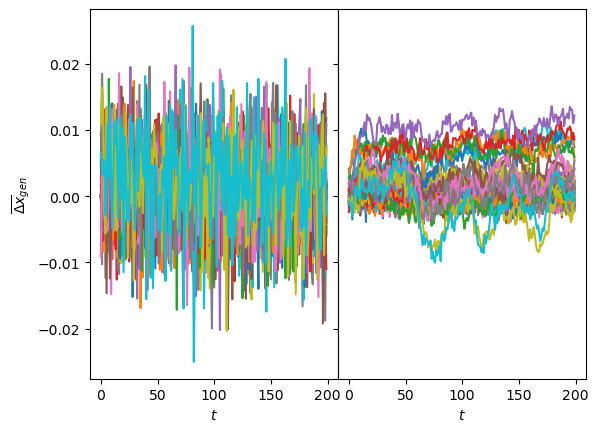

In [ ]:
fig, axs = plt.subplots(1,2, sharey=True, gridspec_kw=dict(wspace=0))
axs[0].plot(disp_gen0.mean(1).T); axs[1].plot(disp_gen1.mean(1).T);
for ax in axs: ax.set_xlabel(r'$t$'); 
axs[0].set_ylabel(r'$\overline{\Delta x}_{gen}$');

The same is supported by the variance of the generated displacements, covering the training range of $D$ for one neuron while the other has a baseline with constant margin and some lines with increased $D$. 

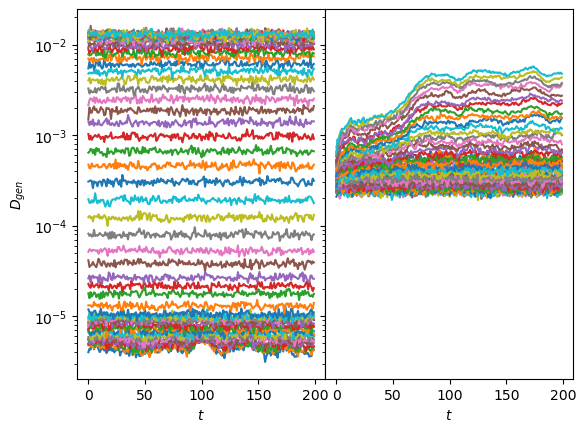

In [ ]:
fig, axs = plt.subplots(1,2, sharey=True, gridspec_kw=dict(wspace=0))
axs[0].semilogy(sig2D(disp_gen0.std(1)).T);
axs[1].semilogy(sig2D(disp_gen1.std(1)).T);
for ax in axs: ax.set_xlabel(r'$t$'); 
axs[0].set_ylabel(r'$D_{gen}$');

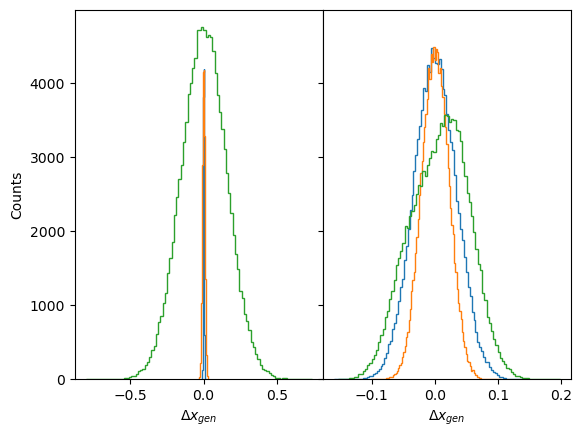

In [ ]:
fig, axs = plt.subplots(1,2, sharey=True, gridspec_kw=dict(wspace=0))
for z_i in [0,30,59]:
    axs[0].hist(disp_gen0[z_i].reshape(-1),100, histtype='step');
    axs[1].hist(disp_gen1[z_i].reshape(-1),100, histtype='step');
for ax in axs: ax.set_xlabel(r'$\Delta x_{gen}$'); 
axs[0].set_ylabel(r'Counts');

## Correlations

In fractional Brownian motion (FBM), the anomalous diffusion arises from the displacements' correlations.
These correlations follow the power-law 
$C
= |\langle \Delta x_t \Delta x_{t+\Delta t}\rangle| /\Delta x_0^2
= \alpha (\alpha-1) D \Delta t^{\alpha-2}$.

When normalized, the correlations slope in logarithmic scale is a manifestation of the anomalous exponent $\alpha$.

In [ ]:
windows = int(disp_gen0.shape[-1]*0.8)
delta_t = np.arange(1,windows)

In [ ]:
disp_gen0.shape

(60, 600, 200)

In [ ]:
def correlations(disp, windows):
    return np.array([np.multiply(disp[...,:-win],disp[...,win:]).mean(-1).mean(-1)  # products mean, samples mean
                      for win in range(1,windows)]).T

In [ ]:
corr_mean0 = correlations(disp_gen0, windows)

In [ ]:
corr_mean1 = np.array([np.multiply(disp_gen1[:,:,:-win], disp_gen1[:,:,win:]
                                  ).mean(-1).mean(-1)  # products mean, samples mean
                      for win in range(1,windows)]).T   

In the following plot, we observe that when varying the first neuron, the slopes remain the same.
When varying the other neuron value, we observe different correlations.
In the case of big $\alpha$, it is clear the correlations are maintained until the receptive field. 

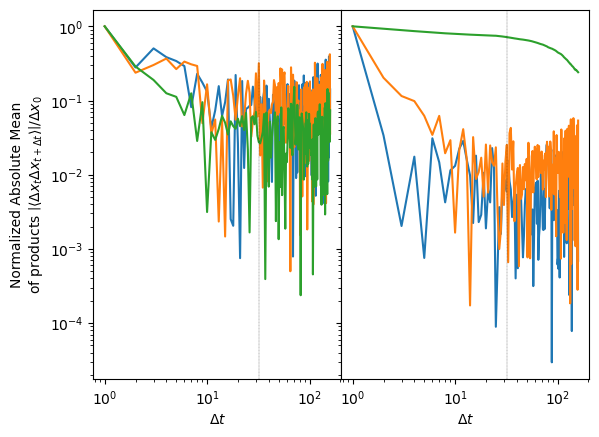

In [ ]:
fig, axs = plt.subplots(1,2, sharey=True, gridspec_kw=dict(wspace=0))
for z_i in [0,30,59]:
    axs[0].loglog(delta_t, np.abs(corr_mean0[z_i]/corr_mean0[z_i,:1]).T);
    axs[1].loglog(delta_t, np.abs(corr_mean1[z_i]/corr_mean1[z_i,:1]).T);
for ax in axs:
    ax.set_xlabel(r'$\Delta t$');
    ax.axvline(learn.model.receptive_field, ls='--', lw=0.2,c='k');
axs[0].set_ylabel("Normalized Absolute Mean\nof products" 
           r" $\left|\langle \Delta x_t\Delta x_{t+\Delta t} \rangle\right|/\Delta x_0}^2$");

## TA-MSD

One prevalent approach employed in the study of single-particle diffusion is to estimate the mean squared displacement (MSD) by utilizing the time-averaged mean squared displacement (TA-MSD).
We can extract both parameters, $\alpha$ and $D$, by fitting the scaling of the TA-MSD.

In [ ]:
from numba import njit, prange, set_num_threads
set_num_threads(2)

# non-jitted version
def TMSD_array_(trajs, t_lags):
    ttt = np.zeros((trajs.shape[0], len(t_lags))) # N trajs, windows
    for idx, t in enumerate(t_lags):
        for p in range(trajs.shape[1]-t):
            ttt[:, idx] += (trajs[:, p]-trajs[:, p+t])**2
        ttt[:, idx] /= trajs.shape[1]-t
    return ttt

@njit
def TAMSD_(traj, t_lags):
    tamsd = np.zeros_like(t_lags, dtype=np.float64)
    for idx, t in enumerate(t_lags):
        for p in range(len(traj) - t):
            tamsd[idx] += (traj[p] - traj[p + t])**2
        tamsd[idx] /= len(traj) - t
    return tamsd

@njit(parallel=True)
def TMSD_array(trajs, t_lags):
    ttt = np.zeros((trajs.shape[0], len(t_lags)), dtype=np.float64)
    for i in prange(trajs.shape[0]):
        ttt[i] = TAMSD_(trajs[i], t_lags)
    return ttt

def TAMSD(trajs, t_lags):
    return TMSD_array(trajs, t_lags)

A common criterion for this technique is to select the initial 10% of the trajectory to perform the  fitting.

In [ ]:
# first 10%
skip = 0
perc = skip + max(4, int(tamsd0.shape[-1]*0.1))-1

log_delta_t = np.log(delta_t[skip:perc])
log_tamsd = np.log(tamsd0[...,skip:perc])
polyfits = np.array([np.polyfit(log_delta_t, log_tamsd[z_i].T, deg=1)
                       for z_i in range(z_num)])
coeffs0 = 0.5*np.exp(polyfits[:,1])
exponents0 = polyfits[:,0]

log_delta_t = np.log(delta_t[skip:perc])
log_tamsd = np.log(tamsd1[...,skip:perc])
polyfits = np.array([np.polyfit(log_delta_t, log_tamsd[z_i].T, deg=1)
                       for z_i in range(z_num)])
coeffs1 = 0.5*np.exp(polyfits[:,1])
exponents1 = polyfits[:,0]

In [ ]:
exponents0.shape, exponents1.shape

((60, 600), (60, 600))

In [ ]:
cmap_latent = 'Blues'

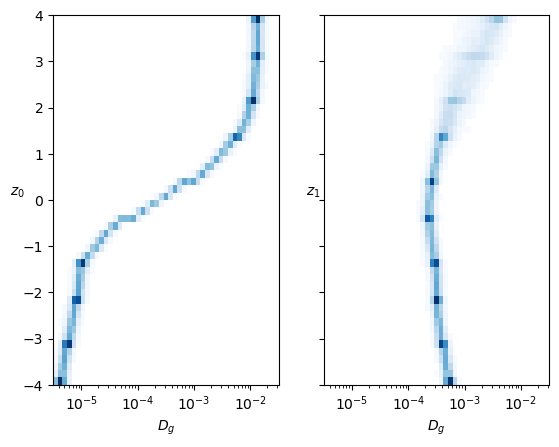

In [ ]:
fig, axs = plt.subplots(1,2, sharey=True,)
logbins = np.geomspace(3.16e-6, 3.16e-2,50)
axs[0].hist2d(coeffs0.reshape(-1),
           np.repeat(z_range.numpy(),coeffs0.shape[-1]),
           bins=(logbins,50), cmap=cmap_latent, cmin=2);
axs[0].set_ylabel(r'$z_0$', rotation=0);
axs[1].hist2d(coeffs1.reshape(-1),
           np.repeat(z_range.numpy(),coeffs1.shape[-1]),
           bins=(logbins,50), cmap=cmap_latent, cmin=2);
axs[1].set_ylabel(r'$z_1$', rotation=0);
for ax in axs:
    ax.set_xlabel(r'$D_g$'); 
    ax.set_xscale('log');

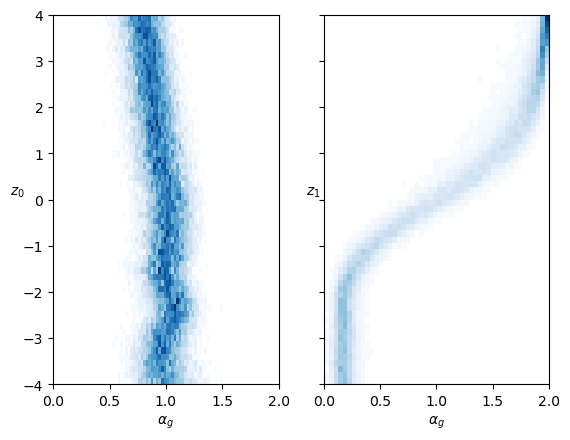

In [ ]:
fig, axs = plt.subplots(1,2, sharey=True,)
axs[0].hist2d(exponents0.reshape(-1),
           np.repeat(z_range.numpy(),exponents0.shape[-1]),
           bins=(50,z_num), cmap=cmap_latent, cmin=2);
axs[0].set_ylabel(r'$z_0$', rotation=0);
axs[1].hist2d(exponents1.reshape(-1),
           np.repeat(z_range.numpy(),exponents1.shape[-1]),
           bins=(50,z_num), cmap=cmap_latent, cmin=2);
axs[1].set_ylabel(r'$z_1$', rotation=0);
for ax in axs:
    ax.set_xlabel(r'$\alpha_g$');
    ax.set_xlim([0,2]);

In both cases, each neuron controls mainly one parameter inside the training range.
The neuron that represents the anomalous exponent $\alpha$ also has a bit of effect on $D$.

# T=6k

The statistical methods to estimate $\alpha$ are based on the average of a high quantity of data points. 
Here, instead of generating more trajectories, we increase the statistics by generating longer trajectories.
This way, we can make a more confident analysis of the estimated $\alpha$ for each time lag.

## Generate displacements 

As in the previous generation, we load the model trained on trajectories with T=400.
Now, instead of generating directly from latent values, we generate from the processed inputs, so we can compare directly with the ground truth.

In [ ]:
DEVICE = 'cpu'
E = 144
model_name = 'fbm' + f'_E{E}'
c_point, model = load_checkpoint("./models/"+model_name,device=DEVICE)
ds_args, model_args = c_point['ds_args'],c_point['model_args']
print(ds_args, model_args)

Loading checkpoint: ./models/fbm_E144.tar
on device: cpu
{'path': '../../data/raw/', 'model': 'fbm', 'N': 476, 'T': 400, 'D': array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02]), 'alpha': array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ,
       1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ]), 'seed': 0, 'valid_pct': 0.2, 'bs': 256, 'N_save': 6000, 'T_save': 400} {'o_dim': 399, 'nc_in': 1, 'nc_out': 6, 'nf': [16, 16, 16, 16], 'avg_size': 16, 'encoder': [200, 100], 'z_dim': 6, 'decoder': [100, 200], 'beta': 0.004, 'in_channels': 1, 'res_channels': 16, 'skip_channels': 16, 'c_channels': 6, 'g_channels': 0, 'res_kernel_size': 3, 'layer_size': 4, 'stack_size': 1, 'out_distribution': 'Normal', 'num_mixtures': 1, 'use_pad': False, 'model_name': 'SPIVAE'}


We choose the number of samples for each parameter combination, the number of samples for each processed input, and the batch size for generation.

In [ ]:
samples_per_c = 100
trajs_per_aD  = 60
T_gen = 6_000
total_samples = trajs_per_aD*samples_per_c
bs = samples_per_c*10
assert not total_samples%bs, 'Using batched generation mode should be using a multiple of the batch size'

We should activate the long generation by adding a parameter in the model that sets the upsampling of the latent representation to the desired length.

In [ ]:
model.vae.Tgen = T_gen+model.receptive_field +1
print(model.vae.Tgen)

6033


For the shake of space, we will exemplify the long generation for a single diffusion coefficient.

In [ ]:
Ds = [1e-3]
alphas = np.linspace(0.04,1.96,49)
n_alphas, n_Ds = len(alphas), len(Ds)

Alert! We will generate around 6 GB of data.

In [ ]:
print(f'{32*T_gen*trajs_per_aD*samples_per_c*n_alphas*n_Ds/(8*1024**3):.2} GB')

6.6 GB


We load the dataset to get the upsampled representations.

In [ ]:
ds_args = dict(path="../../data/test/", model='fbm',
               N=int(trajs_per_aD*n_Ds*1.4),
               T=400,
               D=Ds, alpha=alphas,
               N_save=1_000, T_save=400,
               seed=0, valid_pct=.9, bs=2**8,)

In [ ]:
dls = load_data(ds_args).to(DEVICE)
dls[0].drop_last, dls[1].drop_last, dls[1].bs, dls.device

(True, False, 256, 'cpu')

In [ ]:
loss_fn = Loss(model.receptive_field, model.c_channels, 
                    beta=model_args['beta'], reduction='mean')

learn = Learner(dls, model, loss_func=loss_fn, opt_func=Adam,)
if torch.cuda.is_available() and DEVICE=='cuda': learn.model.cuda()

We get the upsampled latent representations `c` and keep track of the parameters.

In [ ]:
ds_in,preds,ds_targs = learn.get_preds(with_input=True,) # predicts in validation dataset

alphas_items = learn.dls.valid.items[:,0]
Ds_items     = learn.dls.valid.items[:,1]
ds_in_labels = learn.dls.valid.items[:,:2] 
u_a=np.unique(alphas_items,)
u_D=np.unique(Ds_items,)

alphas_idx = [np.flatnonzero(alphas_items==a) for a in u_a]
Ds_idx     = [np.flatnonzero(Ds_items==D)     for D in u_D]

intersect_idx = np.array([[reduce(partial(np.intersect1d,assume_unique=True),
                                  (alphas_idx[i],Ds_idx[j]))
                           for j,D in enumerate(u_D)]
                          for i,a in enumerate(u_a)], dtype=object)

alphas_idx_flat = [item for sublist in alphas_idx for item in sublist]
Ds_idx_flat     = [item for sublist in Ds_idx     for item in sublist]

pred, mu, logvar, c = preds

print(ds_in.shape, learn.dls.valid.items.shape)
print(L(map(len, alphas_idx)), len(alphas_idx_flat), L(map(len, Ds_idx)), len(Ds_idx_flat))

In [ ]:
assert not np.any( np.array(L(map(len, alphas_idx))) < trajs_per_aD ), 'There are not enough trajectories to sample from. Increase N when loading.'

In [ ]:
assert c.shape[-1]>(T_gen+model.receptive_field), 'Has the long mode been activated?'

We sample from the model and save it for each parameter combination.

In [ ]:
for a_idx,a in enumerate(ds_args["alpha"]):
    for D_idx,D in enumerate(ds_args["D"]):
        fname = "../../data/gen/"+model_name+f'_disp_gen_a{a:.3g}D{D:.3g}'.replace('.','')+'.npz'
        if not os.path.exists(fname):
            os.makedirs('../../data/gen/', exist_ok=True)
            indices = (a_idx,D_idx)
            disp_gen, logits = learn.model.sample_batch(total_samples, bs=bs,
                                                        c=c[intersect_idx[indices][:trajs_per_aD]].repeat(samples_per_c,1,1),
                                                        T=T_gen
                                                       )
            disp_gen = disp_gen.squeeze().detach().cpu().numpy()
            np.savez_compressed(fname, disp_gen=disp_gen)
            print("Saved at:", fname)
            print("with dimensions", disp_gen.shape)

  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a168D0001.npz
with dimensions (6000, 6000)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a172D0001.npz
with dimensions (6000, 6000)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a176D0001.npz
with dimensions (6000, 6000)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a18D0001.npz
with dimensions (6000, 6000)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a184D0001.npz
with dimensions (6000, 6000)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a188D0001.npz
with dimensions (6000, 6000)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a192D0001.npz
with dimensions (6000, 6000)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/fbm_E144_disp_gen_a196D0001.npz
with dimensions (6000, 6000)


## Load displacements

Once the displacements are generated and saved, we load them to analyze the correlations and the TA-MSD.

In [ ]:
print('D:', ds_args["D"])
print('a:', ds_args["alpha"])

D: [0.001]
a: [0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52 0.56
 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.   1.04 1.08 1.12
 1.16 1.2  1.24 1.28 1.32 1.36 1.4  1.44 1.48 1.52 1.56 1.6  1.64 1.68
 1.72 1.76 1.8  1.84 1.88 1.92 1.96]


In [ ]:
disp_gen_6k = {f'{a:.3g}'+f',{D:.3g}':[] for D in ds_args["D"] for a in ds_args["alpha"]}

In [ ]:
for a in ds_args["alpha"]:
    for D in ds_args["D"]:
        fname = "../../data/gen/"+model_name+f'_disp_gen_a{a:.3g}D{D:.3g}'.replace('.','')+'.npz'
        with np.load(fname, allow_pickle=True) as f:
            k = f'{a:.3g}'+f',{D:.3g}'
            disp_gen_6k[k] = f['disp_gen']

## Correlations

We compute the correlations of the generated displacements as we did [before](#correlations). 

In [ ]:
disp_corr_6k = {f'{a:.3g}'+f',{D:.3g}':[] for D in ds_args["D"] for a in ds_args["alpha"]}

In [ ]:
windows = 420
delta_t = np.arange(1,windows)
log_delta_t = np.log(delta_t)
for a in ds_args["alpha"][[12,36,48]]:
    for D in ds_args["D"]:
        k = f'{a:.3g}'+f',{D:.3g}'
        disp_corr_6k[k] = correlations(disp_gen_6k[k], windows)

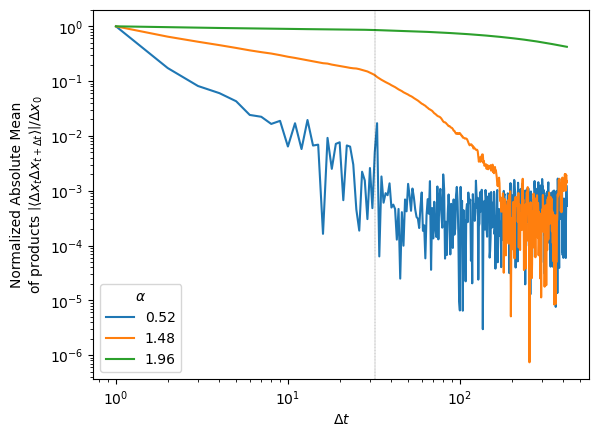

In [ ]:
for a,D in zip(ds_args["alpha"][[12,36,48]],[1e-3]*3):
    k = f'{a:.3g}'+f',{D:.3g}'
    plt.loglog(delta_t, np.abs(disp_corr_6k[k]/disp_corr_6k[k][:1]).T, label=f'{a:.3g}');
plt.xlabel(r'$\Delta t$');
plt.axvline(learn.model.receptive_field, ls='--', lw=0.2,c='k');
plt.ylabel("Normalized Absolute Mean\nof products" 
           r" $\left|\langle \Delta x_t\Delta x_{t+\Delta t} \rangle\right|/\Delta x_0}^2$");
plt.legend(title=r'$\alpha$');

The correlation curves for different exponents $\alpha$ are straight until the time lag $\Delta t$ corresponding to the receptive field where they start to vanish.

## TA-MSD

We analyze the slope of the TA-MSD from the lengthy generated trajectories.

In [ ]:
tamsd_6k = {f'{a:.3g}'+f',{D:.3g}':[] for D in ds_args["D"] for a in ds_args["alpha"]}

In [ ]:
delta_t = np.arange(1,windows)
log_delta_t = np.log(delta_t)
for a in ds_args["alpha"]:
    for D in ds_args["D"]:
        k = f'{a:.3g}'+f',{D:.3g}'
        fname = "../../data/analysis/"+model_name+f'_tamsd_6k_{a:.3g}D{D:.3g}'.replace('.','')+'.npz'
        if not os.path.exists(fname): # create and save
            os.makedirs('../../data/analysis/', exist_ok=True)
            tamsd_6k[k] = TAMSD(np.cumsum(disp_gen_6k[k],axis=-1),delta_t)
            np.savez_compressed(fname, tamsd=tamsd_6k[k])
            print("Saved at:", fname)
            print("with dimensions", tamsd_6k[k].shape)
        else: # load
            with np.load(fname, allow_pickle=True) as f:
            tamsd_6k[k] = f['tamsd']        

We observe the slope remains almost constant up to the time lag corresponding to the receptive field. From there, the curve goes to 1 meaning that correlations are not well reproduced further than the receptive field.

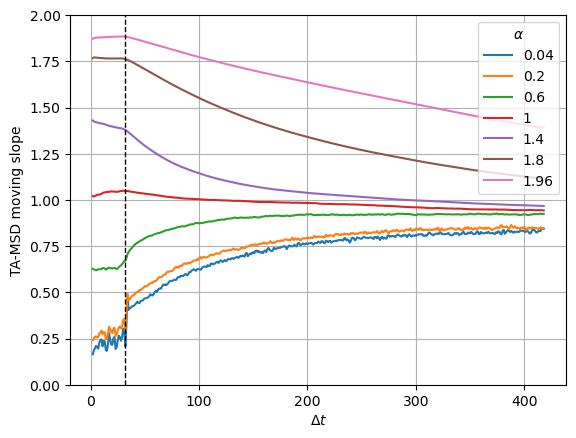

In [ ]:
log_delta_t = np.log(delta_t)
moving_win = 2
for i,a in enumerate(ds_args["alpha"][[0,4,14,24,34,44,48]]):
    for D in ds_args["D"]:
        k = f'{a:.3g}'+f',{D:.3g}'
    log_mean_a = np.log(tamsd_6k[k][:,:windows-1]).mean(0)
    moving_slope_a = (log_mean_a[:-moving_win]-log_mean_a[moving_win:])/(log_delta_t[:-moving_win]-log_delta_t[moving_win:])
    plt.plot(delta_t[moving_win//2:-moving_win//2], moving_slope_a, c=f'C{i}', label=f'{a:.3g}');
plt.xlabel(r'$\Delta t$');    plt.grid(); plt.ylim([0,2])
plt.axvline(learn.model.receptive_field, c='k', lw=1,ls='--');
plt.ylabel("TA-MSD moving slope");
plt.legend(title=r'$\alpha$');

## Get $\alpha$ exponent

We show the difference of taking the fitting before and after the receptive field (RF).

In [ ]:
k = f'{ds_args["alpha"][0]}'+f',{ds_args["D"][0]}'
windows = tamsd_6k[k].shape[-1]
delta_t = np.arange(1,windows)
log_delta_t = np.log(delta_t)
# delta_ts < RF:
skip = 0
perc = skip + max(4, 20)
# delta_ts > RF:
skip_ = 380
perc_ = 400
exponents = {f'{a:.3g}'+f',{D:.3g}':[] for D in ds_args["D"] for a in ds_args["alpha"]}
exponents_ = {f'{a:.3g}'+f',{D:.3g}':[] for D in ds_args["D"] for a in ds_args["alpha"]}
for j,D in enumerate(ds_args["D"]):
    for i,a in enumerate(ds_args["alpha"]):
        k = f'{a:.3g}'+f',{D:.3g}'
        exponents[k]  = np.polyfit(log_delta_t[skip :perc ], np.log(tamsd_6k[k][:,skip :perc ]).T, deg=1)[0]
        exponents_[k] = np.polyfit(log_delta_t[skip_:perc_], np.log(tamsd_6k[k][:,skip_:perc_]).T, deg=1)[0]

In [ ]:
Z_a_r  = np.empty((len(ds_args["alpha"]), len(ds_args['D']),exponents[k].shape[0]))
Z_a_r_ = np.empty((len(ds_args["alpha"]), len(ds_args['D']),exponents_[k].shape[0]))
for j,D in enumerate(ds_args["D"]):
    for i,a in enumerate(ds_args["alpha"]):
        k = f'{a:.3g}'+f',{D:.3g}'
        Z_a_r[i,j]  = exponents[k]
        Z_a_r_[i,j] = exponents_[k]

In [ ]:
traj_per_comb = exponents[k].shape[0]

For time lags smaller than the receptive field, the estimated exponent $\alpha_g$ is very close to the ground truth $\alpha$.
However, for bigger time lags the estimated exponent remains close to  $\alpha=1$ (Brownian motion) meaning the displacements are more uncorrelated.

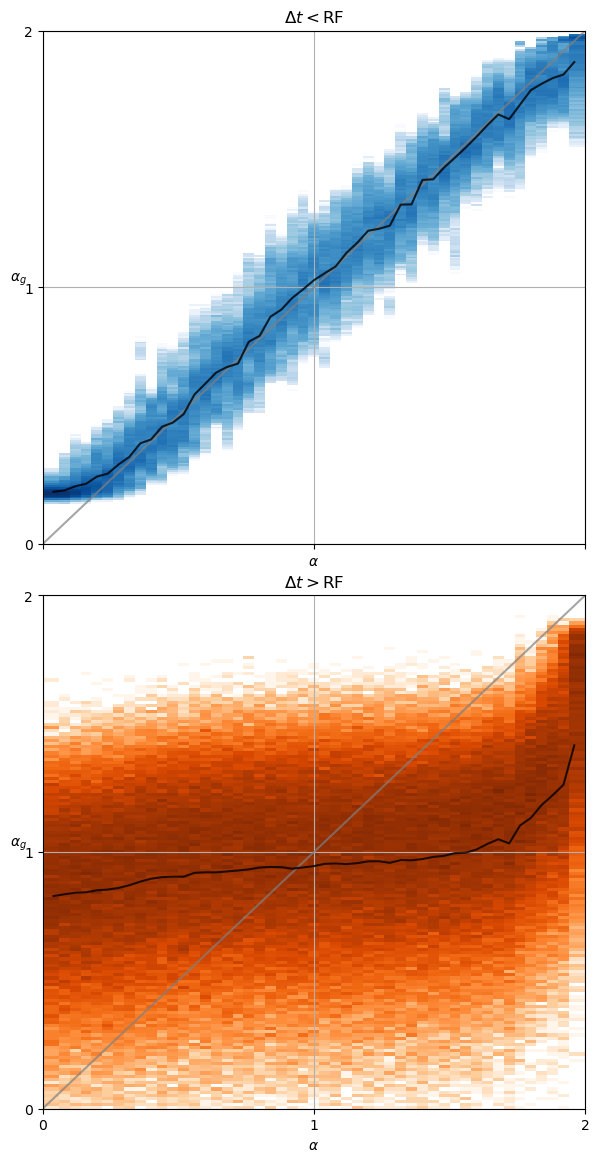

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(7,14), sharex=True, gridspec_kw=dict(hspace=0.1))
for j,D in enumerate(ds_args["D"]):
    x_flat = np.repeat(ds_args["alpha"],traj_per_comb).reshape(-1)
    bins = np.round(np.concatenate(([0],
                                    ds_args["alpha"][1:]-(ds_args["alpha"][1:]-ds_args["alpha"][:-1])*.5,
                                    [2.])),
                    2)
    cmaps = ['Blues', 'Oranges']
    for i, y in enumerate([Z_a_r[:,j],Z_a_r_[:,j]]):
        y_flat = y.reshape(-1)
        axs[i].hist2d(x_flat,y_flat,bins=(bins,250),cmin=2,
                  norm=matplotlib.colors.LogNorm(), cmap=cmaps[i],
                  );
        axs[i].plot([0,1,2], 'gray', alpha=0.7);
        axs[i].plot(ds_args["alpha"], y.mean(-1),'k', alpha=0.8,label='mean');

for ax in axs:
    ax.grid(); ax.set_ylim([0,2]); ax.set_xlim([0,2])
    ax.locator_params(nbins=3); ax.set_ylabel(r"$\alpha_g$", rotation=0);
    ax.set_xlabel(r'$\alpha$');    
axs[0].set_title(r'$\Delta t<$RF');
axs[1].set_title(r'$\Delta t>$RF');